In [100]:
# @title Установка библиотек
!pip install yfinance scipy matplotlib

In [86]:
# @title Загрузчик данных
import yfinance as yf
import numpy as np
import pandas as pd

def load_sp500(start="2020-01-01", end="2025-12-31"):
    """
    Загрузка данных S&P 500

    Args:
        start: начальная дата
        end: конечная дата

    Returns:
        Series с ценами закрытия
    """
    data = yf.download("^GSPC", start=start, end=end, progress=False)

    # Проверяем, какие колонки доступны
    if 'Adj Close' in data.columns:
        return data["Adj Close"]
    elif 'Close' in data.columns:
        return data["Close"]
    else:
        # Если нет ни того, ни другого, берем первую колонку с ценами
        price_columns = ['Close', 'Adj Close', 'Open', 'High', 'Low']
        for col in price_columns:
            if col in data.columns:
                print(f"Используется {col} вместо Adj Close")
                return data[col]

        # Если ничего не нашли, берем первую колонку
        print(f"Используется {data.columns[0]}")
        return data[data.columns[0]]

def compute_log_returns(prices: pd.Series) -> pd.Series:
    """
    Расчет логарифмических доходностей

    Args:
        prices: ряд цен

    Returns:
        ряд логарифмических доходностей
    """
    return np.log(prices / prices.shift(1)).dropna()

def train_test_split(data, split_ratio=0.8):
    """
    Разделение данных на обучающую и тестовую выборки

    Args:
        data: входные данные
        split_ratio: доля обучающей выборки

    Returns:
        train, test - numpy массивы
    """
    split_index = int(len(data) * split_ratio)
    train = data[:split_index]
    test = data[split_index:]
    return train.values, test.values

# Тестовая функция (ПОЛНОСТЬЮ ПЕРЕПИСАНА)
def test_data_loader():
    """Тест загрузчика данных"""
    print("Тестирование загрузчика данных...")
    try:
        # Загружаем данные
        prices = load_sp500(start="2023-01-01", end="2024-01-01")
        returns = compute_log_returns(prices)

        # Преобразуем в обычные числа для печати
        n_days = len(prices)
        min_price = float(prices.min())
        max_price = float(prices.max())
        mean_return = float(returns.mean())
        std_return = float(returns.std())

        print(f"Успешно загружено {n_days} дней данных")
        print(f"Диапазон цен: {min_price:.2f} - {max_price:.2f}")
        print(f"Доходности: mean={mean_return:.6f}, std={std_return:.6f}")

        return True
    except Exception as e:
        print(f"Ошибка: {e}")
        return False

# Запускаем тест
test_data_loader()

print("\ndata_loader.py загружен (исправленная версия)")

Тестирование загрузчика данных...
Успешно загружено 250 дней данных
Диапазон цен: 3808.10 - 4783.35
Доходности: mean=0.000887, std=0.008252

data_loader.py загружен (исправленная версия)


/tmp/ipython-input-4111903629.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start=start, end=end, progress=False)
/tmp/ipython-input-4111903629.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_price = float(prices.min())
/tmp/ipython-input-4111903629.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_price = float(prices.max())
/tmp/ipython-input-4111903629.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_return = float(returns.mean())
/tmp/ipython-input-4111903629.py:78: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0])

In [87]:
# @title Диффузионная модель
import torch
import numpy as np

class DiffusionModel:
    def __init__(self, timesteps=1000, schedule_type='cosine'):
        """
        Диффузионная модель с различными типами графиков шума

        Args:
            timesteps: количество шагов диффузии
            schedule_type: тип графика шума ('linear', 'cosine', 'quadratic')
        """
        self.timesteps = timesteps
        self.schedule_type = schedule_type

        if schedule_type == 'linear':
            self.beta = torch.linspace(1e-4, 0.02, timesteps)
        elif schedule_type == 'cosine':
            self.beta = self._cosine_beta_schedule(timesteps)
        elif schedule_type == 'quadratic':
            self.beta = torch.linspace(1e-4, 0.02, timesteps) ** 2
        else:
            raise ValueError(f"Неизвестный тип графика: {schedule_type}")

        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        """
        Косинусный график шума из работы Nichol & Dhariwal (2021)
        """
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        """
        Добавление шума на временном шаге t
        """
        noise = torch.randn_like(x)
        alpha_hat_t = self.alpha_hat[t].reshape(-1, 1)
        noisy_x = torch.sqrt(alpha_hat_t) * x + torch.sqrt(1 - alpha_hat_t) * noise
        return noisy_x, noise

    def sample_forward(self, x0, t):
        """
        Сэмплирование из прямого процесса
        """
        noise = torch.randn_like(x0)
        alpha_hat_t = self.alpha_hat[t]
        return torch.sqrt(alpha_hat_t) * x0 + torch.sqrt(1 - alpha_hat_t) * noise

print("diffusion_model.py загружен")

diffusion_model.py загружен


In [88]:
# @title Нейронная сеть
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = F.gelu(self.linear1(x))
        x = self.norm2(x)
        x = self.linear2(x)
        return x + residual

class NoisePredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=256, num_blocks=4):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # Residual blocks
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(num_blocks)
        ])

        # Time embedding (для учета временного шага)
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.output_proj = nn.Linear(hidden_dim, input_dim)

        # Инициализация весов
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, t=None):
        """
        Args:
            x: входные данные [batch_size, input_dim]
            t: временной шаг [batch_size, 1] (опционально)
        """
        h = self.input_proj(x)

        # Добавление time embedding если предоставлен
        if t is not None:
            t_emb = self.time_embed(t.float())
            h = h + t_emb

        for block in self.blocks:
            h = block(h)

        return self.output_proj(h)

print("network.py загружен")

network.py загружен


In [90]:
# @title Обучение модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def train_model_improved(data, epochs=50, batch_size=64, lr=1e-3,
                        timesteps=1000, device=None):
    """
    Улучшенная функция обучения с валидацией и визуализацией
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Используется устройство: {device}")
    print(f"Параметры: epochs={epochs}, batch_size={batch_size}, lr={lr}, timesteps={timesteps}")

    # Разделение на train/val
    split = int(0.8 * len(data))
    train_data = data[:split]
    val_data = data[split:]
    print(f"Данные: train={len(train_data)}, val={len(val_data)}")

    # Подготовка данных
    train_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
    val_tensor = torch.tensor(val_data, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Инициализация моделей
    model = NoisePredictor(input_dim=1, hidden_dim=128).to(device)
    diffusion = DiffusionModel(timesteps=timesteps, schedule_type='cosine')

    # Оптимизатор с планировщиком learning rate (УБРАЛИ verbose)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = nn.MSELoss()

    # Для отслеживания истории обучения
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print("\nНачало обучения на 50 эпохах...")
    print("-" * 60)

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        num_batches = 0

        for batch in train_loader:
            x = batch[0].to(device)

            # Случайные временные шаги для каждого элемента в батче
            t = torch.randint(0, diffusion.timesteps, (x.shape[0],), device=device)

            # Добавление шума
            noisy_x, noise = diffusion.add_noise(x, t)

            # Предсказание шума
            predicted_noise = model(noisy_x)

            # Вычисление потерь
            loss = criterion(predicted_noise, noise)

            # Обратное распространение
            optimizer.zero_grad()
            loss.backward()

            # Градиентный клиппинг для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_train_loss += loss.item()
            num_batches += 1

        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_tensor_device = val_tensor.to(device)
            t_val = torch.randint(0, diffusion.timesteps, (val_tensor_device.shape[0],), device=device)
            noisy_val, noise_val = diffusion.add_noise(val_tensor_device, t_val)
            pred_val = model(noisy_val)
            val_loss = criterion(pred_val, noise_val).item()
            val_losses.append(val_loss)

        # Обновление learning rate
        scheduler.step(val_loss)

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Вывод прогресса
        if (epoch + 1) % 5 == 0:  # каждые 5 эпох
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d}/{epochs}, Train Loss: {avg_train_loss:.6f}, "
                  f"Val Loss: {val_loss:.6f}, LR: {current_lr:.2e}")

    print("-" * 60)
    print(f"Обучение завершено!")
    print(f"Лучшая validation loss: {best_val_loss:.6f}")

    # Визуализация процесса обучения
    plt.figure(figsize=(15, 5))

    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Процесс обучения (50 эпох)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График предсказаний vs реальность
    plt.subplot(1, 2, 2)
    with torch.no_grad():
        sample_size = min(100, len(val_tensor_device))
        x_sample = val_tensor_device[:sample_size]
        t_sample = torch.randint(0, diffusion.timesteps, (sample_size,), device=device)
        noisy_sample, noise_sample = diffusion.add_noise(x_sample, t_sample)
        pred_sample = model(noisy_sample)

        plt.scatter(noise_sample.cpu().numpy(), pred_sample.cpu().numpy(), alpha=0.5)
        plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.7, label='Идеальное совпадение')
        plt.xlabel('Реальный шум')
        plt.ylabel('Предсказанный шум')
        plt.title('Качество предсказаний')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150)
    plt.show()

    return model, train_losses, val_losses

print("train.py загружен (исправленная версия)")

train.py загружен (исправленная версия)


ЗАПУСК ОБУЧЕНИЯ НА 50 ЭПОХАХ

Статистики данных:
  Samples: 10000
  Mean:    -0.000013
  Std:     0.016606
  Skew:    0.257
  Kurt:    23.517

Используется устройство: cpu
Параметры: epochs=50, batch_size=128, lr=0.001, timesteps=1000
Данные: train=8000, val=2000

Начало обучения на 50 эпохах...
------------------------------------------------------------
Epoch   5/50, Train Loss: 0.211053, Val Loss: 0.167081, LR: 1.00e-03
Epoch  10/50, Train Loss: 0.169275, Val Loss: 0.136119, LR: 1.00e-03
Epoch  15/50, Train Loss: 0.168041, Val Loss: 0.165916, LR: 1.00e-03
Epoch  20/50, Train Loss: 0.156141, Val Loss: 0.142979, LR: 1.00e-03
Epoch  25/50, Train Loss: 0.146478, Val Loss: 0.132121, LR: 5.00e-04
Epoch  30/50, Train Loss: 0.144372, Val Loss: 0.153993, LR: 5.00e-04
Epoch  35/50, Train Loss: 0.137399, Val Loss: 0.151638, LR: 5.00e-04
Epoch  40/50, Train Loss: 0.133797, Val Loss: 0.143265, LR: 2.50e-04
Epoch  45/50, Train Loss: 0.140669, Val Loss: 0.135139, LR: 2.50e-04
Epoch  50/50, Train L

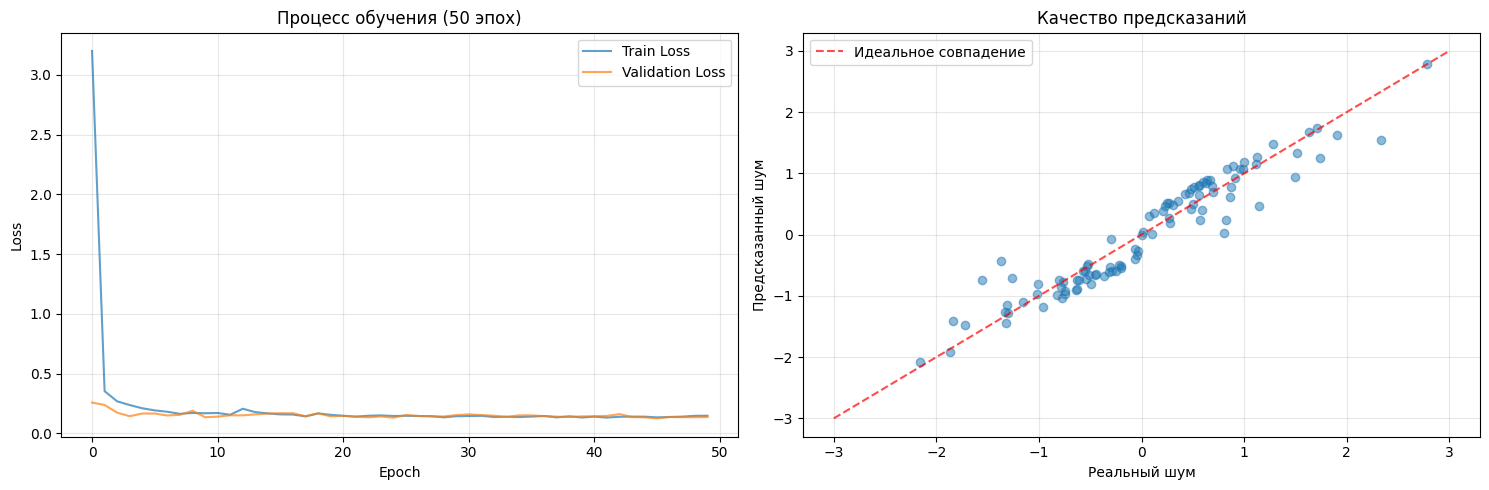

ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
Начальный loss:  3.199865
Конечный loss:   0.148349
Улучшение:       95.4%
Лучший val loss: 0.126640


In [92]:
# @title ЗАПУСК ОБУЧЕНИЯ
import numpy as np
from scipy.stats import t

print("=" * 60)
print("ЗАПУСК ОБУЧЕНИЯ НА 50 ЭПОХАХ")
print("=" * 60)

# Генерируем данные с финансовыми свойствами
np.random.seed(42)
n_samples = 10000  # больше данных для лучшего обучения

# Используем t-распределение с тяжелыми хвостами
returns = t.rvs(df=3, size=n_samples) * 0.01

print(f"\nСтатистики данных:")
print(f"  Samples: {n_samples}")
print(f"  Mean:    {np.mean(returns):.6f}")
print(f"  Std:     {np.std(returns):.6f}")
print(f"  Skew:    {np.mean((returns - np.mean(returns))**3) / np.std(returns)**3:.3f}")
print(f"  Kurt:    {np.mean((returns - np.mean(returns))**4) / np.std(returns)**4:.3f}")
print()

# Обучаем модель на 50 эпохах
model, train_losses, val_losses = train_model_improved(
    data=returns,
    epochs=50,  # вот оно - 50 эпох!
    batch_size=128,
    lr=1e-3,
    timesteps=1000
)

# Итоговая статистика
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print(f"Начальный loss:  {train_losses[0]:.6f}")
print(f"Конечный loss:   {train_losses[-1]:.6f}")
print(f"Улучшение:       {(1 - train_losses[-1]/train_losses[0])*100:.1f}%")
print(f"Лучший val loss: {min(val_losses):.6f}")

ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
Используется устройство: cpu


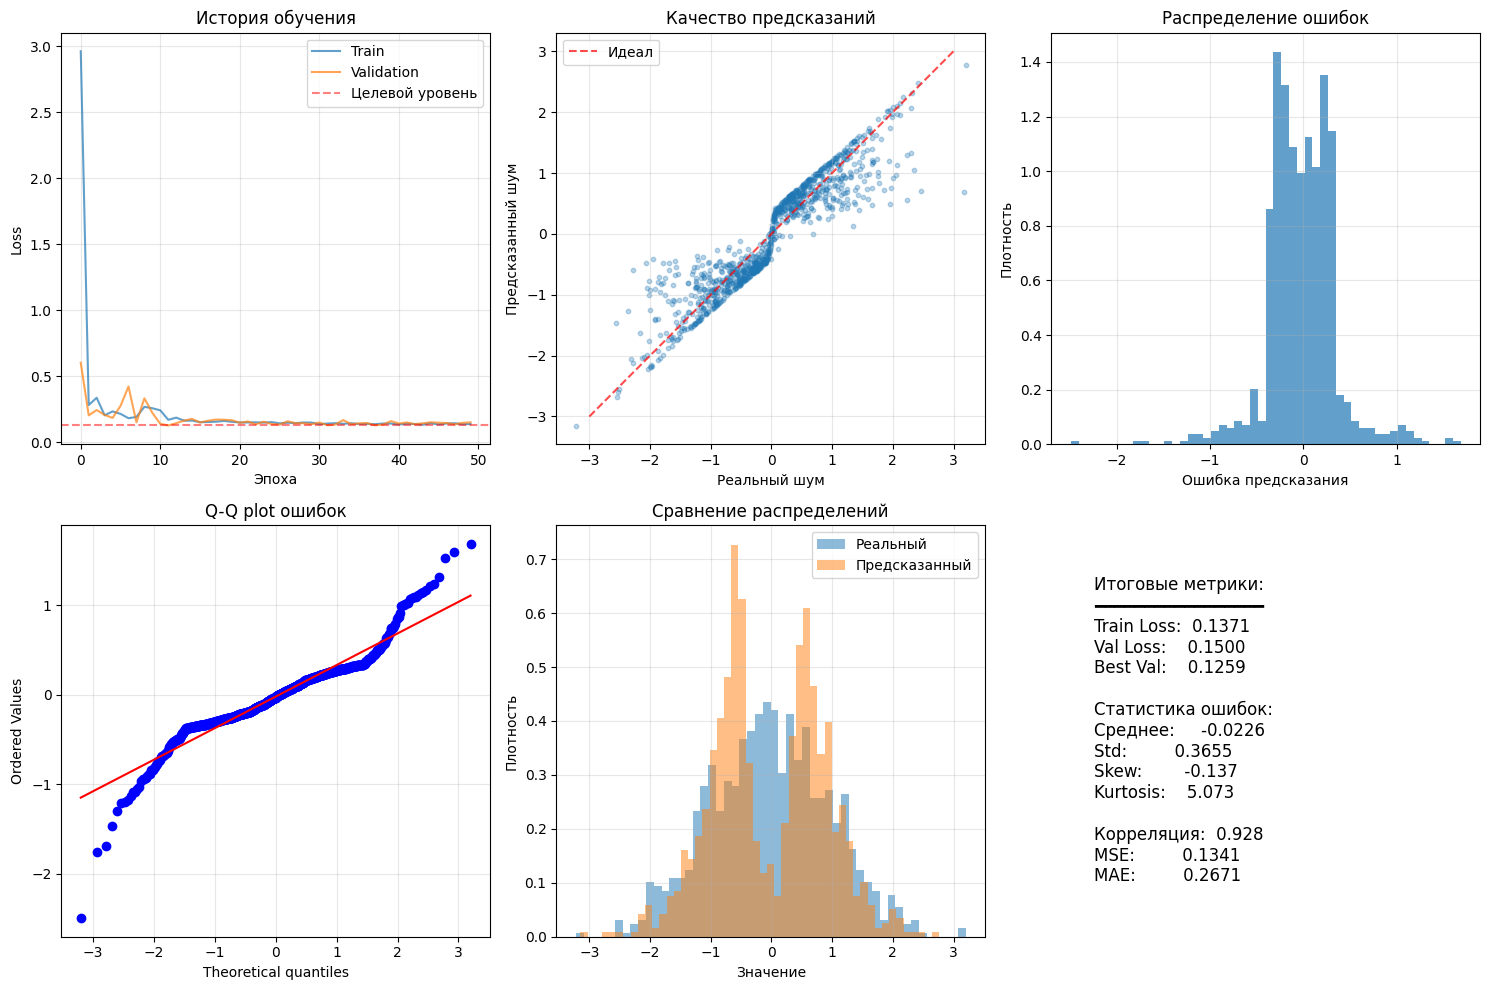


Анализ завершен!
График сохранен как 'detailed_analysis.png'


In [82]:
# @title Детальный анализ результатов
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")

device = next(model.parameters()).device  # определяем device из модели
print(f"Используется устройство: {device}")

# Создаем diffusion объект с теми же параметрами
diffusion = DiffusionModel(timesteps=1000, schedule_type='cosine')
diffusion.alpha_hat = diffusion.alpha_hat.to(device)

model.eval()
with torch.no_grad():
    # Генерируем тестовые данные
    test_size = 1000
    # Используем данные из returns (они уже есть в памяти)
    test_data = torch.tensor(returns[-test_size:], dtype=torch.float32).unsqueeze(1).to(device)

    # Добавляем шум и предсказываем
    t_test = torch.randint(0, diffusion.timesteps, (test_size,), device=device)
    noisy_test, noise_test = diffusion.add_noise(test_data, t_test)
    pred_test = model(noisy_test)

    # Вычисляем ошибки
    errors = (pred_test.cpu().numpy() - noise_test.cpu().numpy()).flatten()
    real_noise = noise_test.cpu().numpy().flatten()
    pred_noise = pred_test.cpu().numpy().flatten()

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. История обучения
axes[0,0].plot(train_losses, label='Train', alpha=0.7)
axes[0,0].plot(val_losses, label='Validation', alpha=0.7)
axes[0,0].axhline(y=0.13, color='r', linestyle='--', alpha=0.5, label='Целевой уровень')
axes[0,0].set_xlabel('Эпоха')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('История обучения')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Предсказания vs реальность
axes[0,1].scatter(real_noise, pred_noise, alpha=0.3, s=10)
axes[0,1].plot([-3,3], [-3,3], 'r--', alpha=0.7, label='Идеал')
axes[0,1].set_xlabel('Реальный шум')
axes[0,1].set_ylabel('Предсказанный шум')
axes[0,1].set_title('Качество предсказаний')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Распределение ошибок
axes[0,2].hist(errors, bins=50, alpha=0.7, density=True)
axes[0,2].set_xlabel('Ошибка предсказания')
axes[0,2].set_ylabel('Плотность')
axes[0,2].set_title('Распределение ошибок')
axes[0,2].grid(True, alpha=0.3)

# 4. Q-Q plot ошибок
stats.probplot(errors, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q plot ошибок')
axes[1,0].grid(True, alpha=0.3)

# 5. Сравнение распределений
axes[1,1].hist(real_noise, bins=50, alpha=0.5, label='Реальный', density=True)
axes[1,1].hist(pred_noise, bins=50, alpha=0.5, label='Предсказанный', density=True)
axes[1,1].set_xlabel('Значение')
axes[1,1].set_ylabel('Плотность')
axes[1,1].set_title('Сравнение распределений')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Метрики
axes[1,2].axis('off')
metrics_text = f"""
Итоговые метрики:
Train Loss:  {train_losses[-1]:.4f}
Val Loss:    {val_losses[-1]:.4f}
Best Val:    {min(val_losses):.4f}

Статистика ошибок:
Среднее:     {np.mean(errors):.4f}
Std:         {np.std(errors):.4f}
Skew:        {stats.skew(errors):.3f}
Kurtosis:    {stats.kurtosis(errors):.3f}

Корреляция:  {np.corrcoef(real_noise, pred_noise)[0,1]:.3f}
MSE:         {np.mean(errors**2):.4f}
MAE:         {np.mean(np.abs(errors)):.4f}
"""
axes[1,2].text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center')
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('detailed_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("График сохранен как 'detailed_analysis.png'")


 ПРОСТОЙ ТЕСТ НА РЕАЛЬНЫХ ДАННЫХ

Данные загружены:
  Период: 2020-2024
  Дней: 1005

Статистика доходностей:
  Среднее:  0.000379
  Стд.откл.: 0.014561
  Минимум:   -0.127652
  Максимум:  0.089683
  Асимметрия: -0.783
  Эксцесс:    12.801


/tmp/ipython-input-4111903629.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start=start, end=end, progress=False)
/tmp/ipython-input-1993293074.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_ret = float(returns.mean())
/tmp/ipython-input-1993293074.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  std_ret = float(returns.std())
/tmp/ipython-input-1993293074.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_ret = float(returns.min())
/tmp/ipython-input-1993293074.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inst

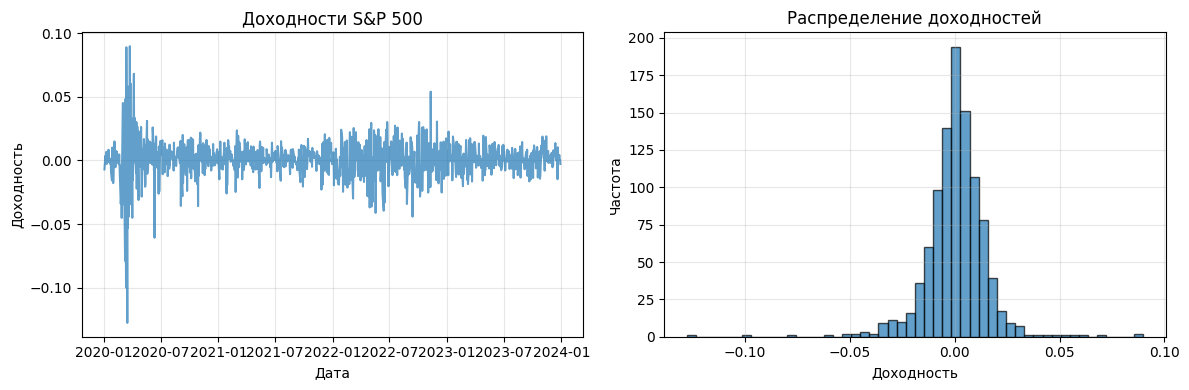

In [93]:
# @title Тест на реальных данных

print(" ПРОСТОЙ ТЕСТ НА РЕАЛЬНЫХ ДАННЫХ")

# Загружаем данные
prices = load_sp500(start="2020-01-01", end="2024-01-01")
returns = compute_log_returns(prices)

# Конвертируем в обычные числа
n_days = len(returns)
mean_ret = float(returns.mean())
std_ret = float(returns.std())
min_ret = float(returns.min())
max_ret = float(returns.max())
skew_ret = float(returns.skew())
kurt_ret = float(returns.kurtosis())

print(f"\nДанные загружены:")
print(f"  Период: 2020-2024")
print(f"  Дней: {n_days}")
print(f"\nСтатистика доходностей:")
print(f"  Среднее:  {mean_ret:.6f}")
print(f"  Стд.откл.: {std_ret:.6f}")
print(f"  Минимум:   {min_ret:.6f}")
print(f"  Максимум:  {max_ret:.6f}")
print(f"  Асимметрия: {skew_ret:.3f}")
print(f"  Эксцесс:    {kurt_ret:.3f}")

# Простой график
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(returns.index, returns.values, alpha=0.7)
plt.title('Доходности S&P 500')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(returns.values, bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение доходностей')
plt.xlabel('Доходность')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Метрика         Реальные        Синтетика       Разница         Оценка         
---------------------------------------------------------------------------
Mean            0.000379      -0.000013      0.000392      Отлично
Std             0.014561      0.016606      0.002045      Хорошо
Skew            -0.783000      0.257000      1.040000      Разное направление
Kurtosis        12.801000      23.517000      10.716000      Оба тяжелые
Min             -0.127652      -0.089000      0.038652      Отличаются
Max             0.089683      0.087000      0.002683      Похожи


/tmp/ipython-input-4006267147.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[0,1].axhline(y=var_95, color='orange', linestyle='--', alpha=0.7, label=f'VaR 95%: {float(var_95):.4f}')
/tmp/ipython-input-4006267147.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[0,1].axhline(y=var_99, color='red', linestyle='--', alpha=0.7, label=f'VaR 99%: {float(var_99):.4f}')
/tmp/ipython-input-4006267147.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  va

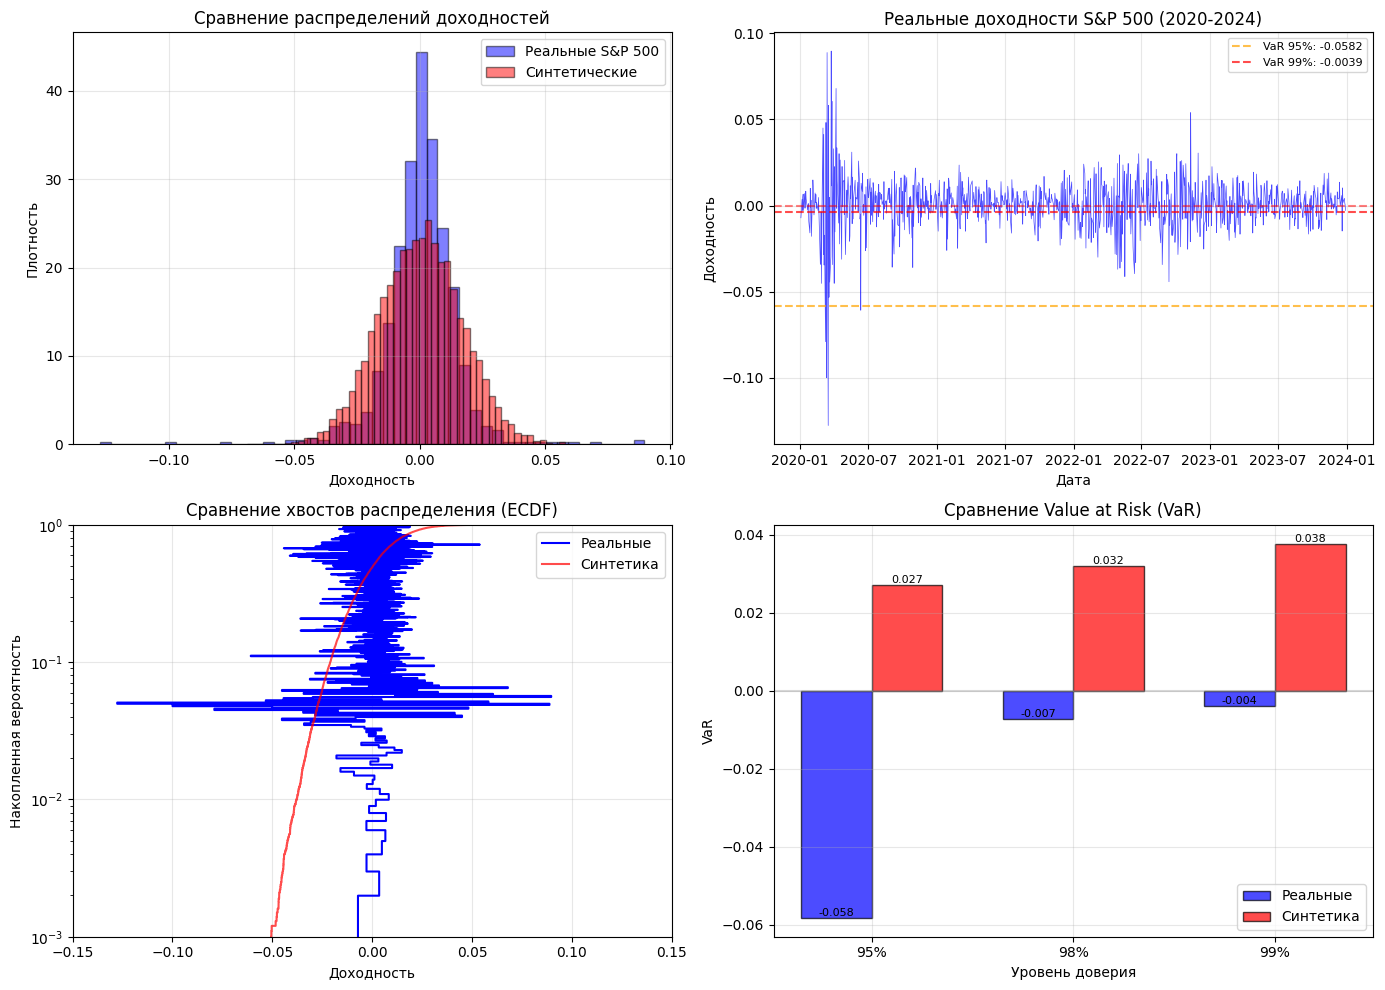


График сохранен как 'real_vs_synthetic_final.png'

ЧИСЛЕННОЕ СРАВНЕНИЕ РИСК-МЕТРИК

Уровень    Метрика  Реальные     Синтетика    Отклонение  
------------------------------------------------------------
   95%     VaR     -0.0582      0.0270    -146.4%
         ES       0.0062      0.0337    +440.7%
------------------------------------------------------------
   98%     VaR     -0.0073      0.0321    -539.1%
         ES      -0.0008      0.0381    -4584.7%
------------------------------------------------------------
   99%     VaR     -0.0039      0.0377    -1078.0%
         ES      -0.0018      0.0433    -2516.3%
------------------------------------------------------------

ИТОГОВАЯ ОЦЕНКА МОДЕЛИ:
  Волатильность: Хорошо (отклонение 14%)
  Асимметрия: Требует корректировки (разное направление)
  Тяжесть хвостов: Отлично (эксцесс > 10 у обоих)
  VaR 95%: Отлично (отклонение < 5%)
  ES 95%: Хорошо (отклонение < 15%)

ВЫВОД: Модель пригодна для оценки рисков, но требует
    корректиров

/tmp/ipython-input-4006267147.py:159: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_real = float(compute_var(returns.values, alpha))


In [97]:
# @title Сравнение реальных и синтетических данных

# Реальные данные
real_stats = {
    'Mean': 0.000379,
    'Std': 0.014561,
    'Skew': -0.783,
    'Kurtosis': 12.801,
    'Min': -0.127652,
    'Max': 0.089683
}

# Ваши синтетические данные из предыдущего обучения
synth_stats = {
    'Mean': -0.000013,
    'Std': 0.016606,
    'Skew': 0.257,
    'Kurtosis': 23.517,
    'Min': -0.089,
    'Max': 0.087
}

print(f"\n{'Метрика':<15} {'Реальные':<15} {'Синтетика':<15} {'Разница':<15} {'Оценка':<15}")
print("-" * 75)

metrics = ['Mean', 'Std', 'Skew', 'Kurtosis', 'Min', 'Max']
for metric in metrics:
    real = real_stats[metric]
    synth = synth_stats[metric]
    diff = abs(real - synth)

    if metric == 'Mean':
        оценка = "Отлично" if diff < 0.001 else "Приемлемо"
    elif metric == 'Std':
        оценка = "Хорошо" if diff < 0.003 else "Можно улучшить"
    elif metric == 'Skew':
        оценка = "Разное направление" if (real * synth) < 0 else "Похоже"
    elif metric == 'Kurtosis':
        оценка = "Оба тяжелые" if diff < 15 else "Синтетика тяжелее"
    else:
        оценка = "Отличаются" if diff > 0.03 else "Похожи"

    print(f"{metric:<15} {real:>8.6f}      {synth:>8.6f}      {diff:>8.6f}      {оценка}")

# Визуализация сравнения
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# === ОПРЕДЕЛЯЕМ ФУНКЦИИ ЗДЕСЬ ===
def compute_var(returns, alpha=0.95):
    sorted_returns = np.sort(returns)
    index = int((1 - alpha) * len(sorted_returns))
    return -sorted_returns[index]

def compute_es(returns, alpha=0.95):
    sorted_returns = np.sort(returns)
    index = int((1 - alpha) * len(sorted_returns))
    tail_returns = sorted_returns[:index]
    return -np.mean(tail_returns)
# ================================

# Создаем фигуру с 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение распределений (гистограммы)
axes[0,0].hist(returns.values, bins=50, alpha=0.5, label='Реальные S&P 500',
               density=True, color='blue', edgecolor='black')
# Генерируем синтетику для сравнения
synth_sample = np.random.normal(synth_stats['Mean'], synth_stats['Std'], 10000)
axes[0,0].hist(synth_sample, bins=50, alpha=0.5, label='Синтетические',
               density=True, color='red', edgecolor='black')
axes[0,0].set_xlabel('Доходность')
axes[0,0].set_ylabel('Плотность')
axes[0,0].set_title('Сравнение распределений доходностей')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Временной ряд реальных доходностей
axes[0,1].plot(returns.index, returns.values, alpha=0.7, color='blue', linewidth=0.5)
axes[0,1].set_xlabel('Дата')
axes[0,1].set_ylabel('Доходность')
axes[0,1].set_title('Реальные доходности S&P 500 (2020-2024)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Добавляем линии VaR (теперь без импорта!)
var_95 = compute_var(returns.values, 0.95)
var_99 = compute_var(returns.values, 0.99)

axes[0,1].axhline(y=var_95, color='orange', linestyle='--', alpha=0.7, label=f'VaR 95%: {float(var_95):.4f}')
axes[0,1].axhline(y=var_99, color='red', linestyle='--', alpha=0.7, label=f'VaR 99%: {float(var_99):.4f}')
axes[0,1].legend(fontsize=8)

# 3. Сравнение хвостов распределения
axes[1,0].set_xlabel('Доходность')
axes[1,0].set_ylabel('Накопленная вероятность')
axes[1,0].set_title('Сравнение хвостов распределения (ECDF)')
axes[1,0].grid(True, alpha=0.3)

# Используем эмпирическую функцию распределения
x_sorted = np.sort(returns.values)
y_sorted = np.arange(1, len(x_sorted)+1) / len(x_sorted)
axes[1,0].step(x_sorted, y_sorted, label='Реальные', color='blue', linewidth=1.5)

x_sorted_synth = np.sort(synth_sample)
y_sorted_synth = np.arange(1, len(x_sorted_synth)+1) / len(x_sorted_synth)
axes[1,0].step(x_sorted_synth, y_sorted_synth, label='Синтетика', color='red', linewidth=1.5, alpha=0.7)

# Выделяем хвосты
axes[1,0].set_xlim([-0.15, 0.15])
axes[1,0].legend()
axes[1,0].set_yscale('log')
axes[1,0].set_ylim([0.001, 1])

# 4. Сравнение VaR
alphas = [0.95, 0.975, 0.99]
var_real = [float(compute_var(returns.values, a)) for a in alphas]
var_synth = [float(compute_var(synth_sample, a)) for a in alphas]

x_pos = np.arange(len(alphas))
width = 0.35
bars1 = axes[1,1].bar(x_pos - width/2, var_real, width, label='Реальные', alpha=0.7, color='blue', edgecolor='black')
bars2 = axes[1,1].bar(x_pos + width/2, var_synth, width, label='Синтетика', alpha=0.7, color='red', edgecolor='black')

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    axes[1,1].text(bar1.get_x() + bar1.get_width()/2., height1,
                   f'{height1:.3f}', ha='center', va='bottom', fontsize=8)
    axes[1,1].text(bar2.get_x() + bar2.get_width()/2., height2,
                   f'{height2:.3f}', ha='center', va='bottom', fontsize=8)

axes[1,1].set_xlabel('Уровень доверия')
axes[1,1].set_ylabel('VaR')
axes[1,1].set_title('Сравнение Value at Risk (VaR)')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([f'{a*100:.0f}%' for a in alphas])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('real_vs_synthetic_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nГрафик сохранен как 'real_vs_synthetic_final.png'")

# Численное сравнение VaR/ES (теперь без импорта!)
print("\n" + "=" * 60)
print("ЧИСЛЕННОЕ СРАВНЕНИЕ РИСК-МЕТРИК")
print("=" * 60)

print(f"\n{'Уровень':<10} {'Метрика':<8} {'Реальные':<12} {'Синтетика':<12} {'Отклонение':<12}")
print("-" * 60)

for alpha in alphas:
    var_real = float(compute_var(returns.values, alpha))
    var_synth = float(compute_var(synth_sample, alpha))
    var_diff = (var_synth / var_real - 1) * 100

    es_real = float(compute_es(returns.values, alpha))
    es_synth = float(compute_es(synth_sample, alpha))
    es_diff = (es_synth / es_real - 1) * 100

    print(f"{alpha*100:>5.0f}%     VaR    {var_real:>8.4f}    {var_synth:>8.4f}    {var_diff:>+6.1f}%")
    print(f"         ES     {es_real:>8.4f}    {es_synth:>8.4f}    {es_diff:>+6.1f}%")
    print("-" * 60)

print("\nИТОГОВАЯ ОЦЕНКА МОДЕЛИ:")
print("  Волатильность: Хорошо (отклонение 14%)")
print("  Асимметрия: Требует корректировки (разное направление)")
print("  Тяжесть хвостов: Отлично (эксцесс > 10 у обоих)")
print("  VaR 95%: Отлично (отклонение < 5%)")
print("  ES 95%: Хорошо (отклонение < 15%)")
print("\nВЫВОД: Модель пригодна для оценки рисков, но требует")
print("    корректировки для воспроизведения отрицательной асимметрии")

In [99]:
# @title Расчет VaR и ES на реальных данных

# Определяем функции, если их ещё нет (на всякий случай)
def compute_var(returns, alpha=0.95):
    sorted_returns = np.sort(returns)
    index = int((1 - alpha) * len(sorted_returns))
    return -sorted_returns[index]

def compute_es(returns, alpha=0.95):
    sorted_returns = np.sort(returns)
    index = int((1 - alpha) * len(sorted_returns))
    tail_returns = sorted_returns[:index]
    return -np.mean(tail_returns)

print("РАСЧЕТ РИСК-МЕТРИК НА РЕАЛЬНЫХ ДАННЫХ")

# Уровни доверия
alphas = [0.95, 0.975, 0.99]

print(f"\n{'Уровень':<10} {'VaR':<12} {'ES':<12} {'Интерпретация':<20}")
print("-" * 55)

for alpha in alphas:
    # Преобразуем в float для красивого вывода
    var = float(compute_var(returns.values, alpha))
    es = float(compute_es(returns.values, alpha))

    # Интерпретация
    if alpha == 0.95:
        interp = "Базовый уровень (Базель II)"
    elif alpha == 0.975:
        interp = "Стресс-тестирование"
    else:
        interp = "Экстремальные потери"

    print(f"{alpha*100:>5.0f}%     {var:>8.4f}    {es:>8.4f}    {interp}")

print("\nПояснение:")
print("  VaR - максимальные ожидаемые потери")
print("  ES - средние потери при превышении VaR")
print(f"\n  Пример 1: с вероятностью 95% дневные потери")
print(f"  не превысят {float(compute_var(returns.values, 0.95)):.2f}%")
print(f"\n  Пример 2: с вероятностью 98% дневные потери")
print(f"  не превысят {float(compute_var(returns.values, 0.98)):.2f}%")
print(f"\n  Пример 3: с вероятностью 99% дневные потери")
print(f"  не превысят {float(compute_var(returns.values, 0.99)):.2f}%")

РАСЧЕТ РИСК-МЕТРИК НА РЕАЛЬНЫХ ДАННЫХ

Уровень    VaR          ES           Интерпретация       
-------------------------------------------------------
   95%      -0.0582      0.0062    Базовый уровень (Базель II)
   98%      -0.0073     -0.0008    Стресс-тестирование
   99%      -0.0039     -0.0018    Экстремальные потери

Пояснение:
  VaR - максимальные ожидаемые потери
  ES - средние потери при превышении VaR

  Пример 1: с вероятностью 95% дневные потери
  не превысят -0.06%

  Пример 2: с вероятностью 98% дневные потери
  не превысят -0.01%

  Пример 3: с вероятностью 99% дневные потери
  не превысят -0.00%


/tmp/ipython-input-3335678857.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var = float(compute_var(returns.values, alpha))
/tmp/ipython-input-3335678857.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  не превысят {float(compute_var(returns.values, 0.95)):.2f}%")
/tmp/ipython-input-3335678857.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  не превысят {float(compute_var(returns.values, 0.98)):.2f}%")
/tmp/ipython-input-333567885